In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json
from tqdm import tqdm
import os
import json

from utils import (
    convert_coco_to_masklet_format,
    visualize_formatted_frame_output,
    prepare_masks_for_visualization,
)

Converting 5000 RGB samples to LAB color space...
Conversion to LAB complete.
Fitting KMeans with 128 clusters on 5000 samples...
KMeans fitting complete.


In [7]:
# Ground truth data paths
gt_ann_file = gt_path = '../assets/gold_video_eval/09242025/saco_veval_sav_val.json' 
frames_directory = '/checkpoint/sam3/shared/data/ta_data_center/auto_sync/release/public_release/sav/sav_val_after_swap/JPEGImages_24fps'

video_id = 'sav_000262'
num_frames = 10
show_every=1

# Get available video IDs from ground truth
with open(gt_ann_file, 'r') as f:
    gt_data_example = json.load(f)

Preparing GT visualization: 100%|██████████| 10/10 [00:00<00:00, 33.00it/s]


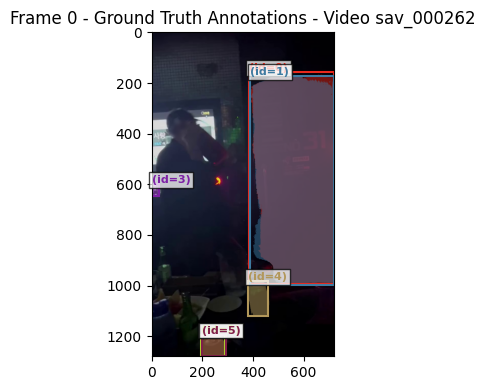

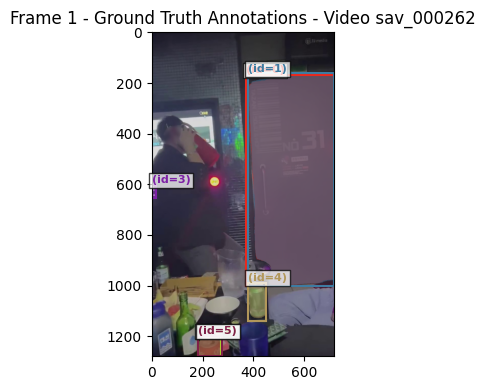

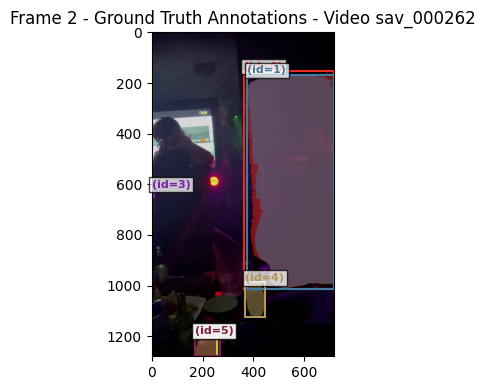

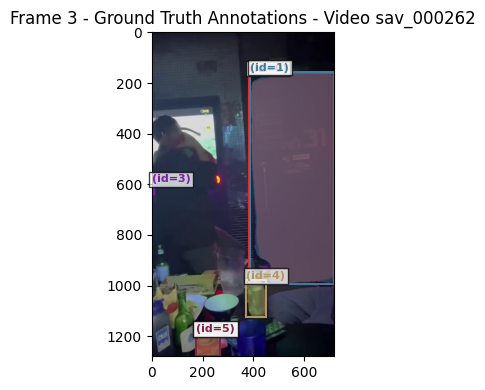

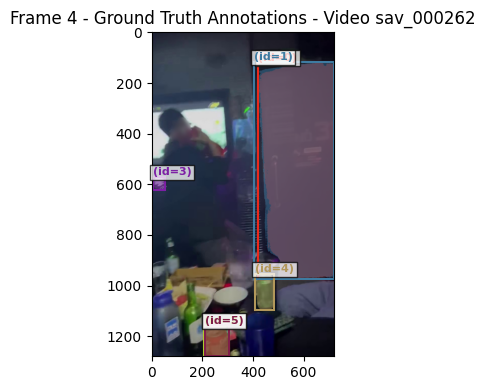

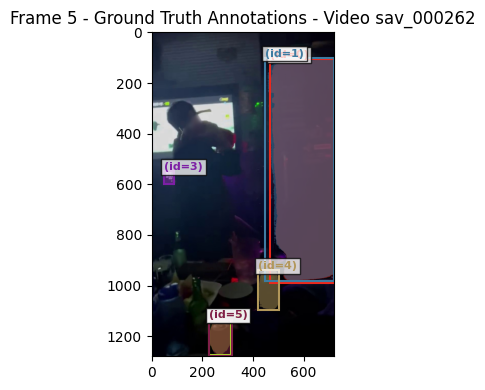

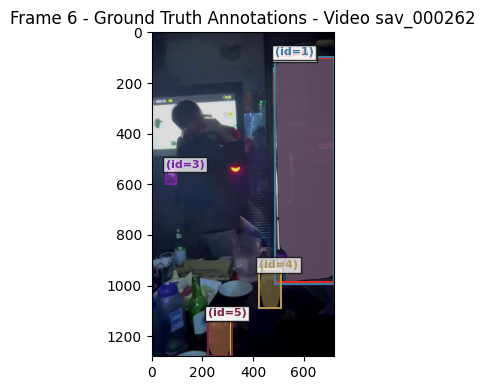

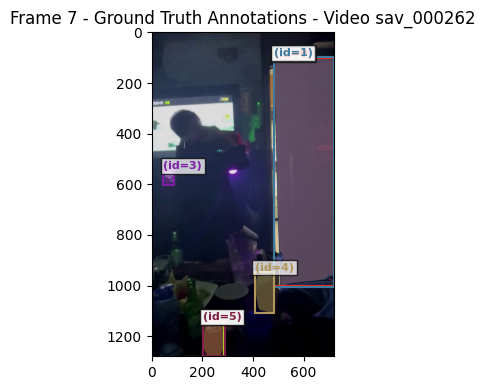

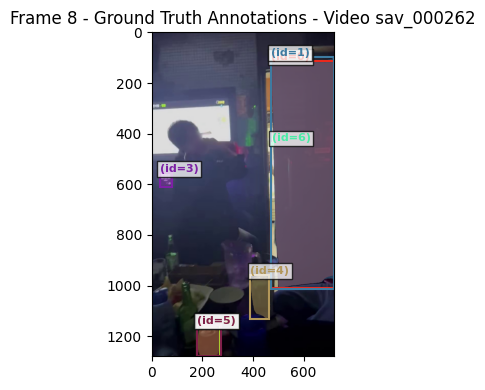

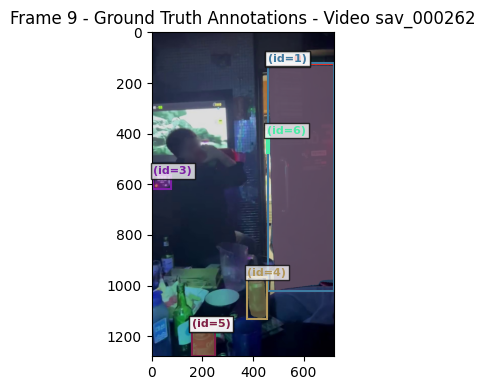

In [8]:
with open(gt_ann_file, 'r') as f:
    groundtruth = json.load(f)

# Extract file names for the specified video_id
video_info = next((video for video in groundtruth['videos'] if video['id'] == video_id), None)
file_names = video_info['file_names']
gt_annotations = [ann for ann in groundtruth['annotations'] if ann['video_id'] == video_id]
image_files = [os.path.join(frames_directory, file_name) for file_name in file_names[:num_frames]]

# Prepare outputs for all frames
outputs_per_frame = {}
for frame_idx, file_name in enumerate(tqdm(file_names[:num_frames], desc="Preparing GT visualization")):
    if frame_idx % show_every != 0:
        continue

    frame_path = os.path.join(frames_directory, file_name)
    frame = np.array(Image.open(frame_path).convert("RGB"))
    img_h, img_w = frame.shape[:2]

    coco_annotations = []
    img_info = {'width': img_w, 'height': img_h}

    for ann in gt_annotations:
        if frame_idx < len(ann['bboxes']) and ann['bboxes'][frame_idx] is not None:
            bbox = ann['bboxes'][frame_idx]
            segmentation = ann['segmentations'][frame_idx] if 'segmentations' in ann and frame_idx < len(ann['segmentations']) else None

            coco_ann = {
                'bbox': bbox,
                'segmentation': segmentation
            }
            coco_annotations.append(coco_ann)
    # Convert to masklet format using utils function
    masklet_outputs =  convert_coco_to_masklet_format(
        coco_annotations, img_info, is_prediction=False, return_numpy=True
    )
    outputs_per_frame[frame_idx] = masklet_outputs

# Prepare masks for visualization
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

# Visualize frames using the same style as dense video tracking
vis_frame_stride = show_every
plt.close("all")
for frame_idx in range(0, min(num_frames, len(file_names)), vis_frame_stride):
    if frame_idx in outputs_per_frame:
        visualize_formatted_frame_output(
            frame_idx,
            image_files,
            outputs_list=[outputs_per_frame],
            titles=[f"Ground Truth Annotations - Video {video_id}"],
            figsize=(6, 4),
        )
